In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
from HTV_Delaunay import MyDelaunay
from opt_solver import *
import pandas as pd
import numpy as np
import pickle

In [2]:
np.random.seed(2022)
data = np.array(pd.read_excel('4d-data.xlsx'))

X = data[:, 0:4]
y = data[:, 4]

valid_mses_all = list()
train_mses_all = list()
best_test_mses = list()
best_train_mses = list()
best_lmbdas = list()

for trial in range(50): 
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.۱)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

    sc = StandardScaler()
    sc.fit(X_train)

    X_train_n = sc.transform(X_train)
    X_valid_n = sc.transform(X_valid)
    X_test_n = sc.transform(X_test)

    print('train data size: ', X_train.shape, '\nvalidation data size: ', X_valid.shape, '\ntest data size: ', X_test.shape)

    load = False
    if not load:
        tri = MyDelaunay(X_train_n, y_train)
        tri.construct_forward_matrix()
        tri.construct_regularization_matrix()
        file_to_store = open("tri_4d.pickle", "wb")
        pickle.dump(tri, file_to_store)
        file_to_store.close()
    else:
        file_to_read = open("tri_4d.pickle", "rb")
        tri = pickle.load(file_to_read)
        file_to_read.close()

    lmbdas = [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5]
    niters = [100000, 100000, 100000, 100000, 100000, 100000, 100000, 200000, 400000]

    train_mses = list()
    valid_mses= list()
    fista_solutions = list()

    for i in range(len(lmbdas)): 
        print('lmbda is ', lmbdas[i])
        y_fista, _, _ = fista_for_dual_gpu3(tri.grid_values, tri.L, tri.s, lmbdas[i], niters[i])
        fista_solutions.append(y_fista.detach().cpu().numpy())
        valid_htv = tri.evaluate(X_valid_n, fista_solutions[i])
        train_htv = tri.evaluate(X_train_n, fista_solutions[i])
        valid_mse = np.mean((y_valid - valid_htv)**2)
        train_mse = np.mean((y_train - train_htv)**2)
        train_mses.append(train_mse)
        valid_mses.append(valid_mse)

    best_lmbda_idx = np.argmin(valid_mses)
    test_htv = tri.evaluate(X_test_n, fista_solutions[best_lmbda_idx])
    test_mse = np.mean((y_test - test_htv)**2)

    valid_mses_all.append(valid_mses)
    train_mses_all.append(train_mses)
    best_test_mses.append(test_mse)
    best_train_mses.append(train_mses)
    best_lmbdas.append(lmbdas[best_lmbda_idx])

train data size:  (5740, 4) 
validation data size:  (1914, 4) 
test data size:  (1914, 4)
lmbda is  0
0 0.0 660744.7533616822 0.0 591136141.3300501
20000 0.0 660744.7533616822 0.0 591136141.3300501
40000 0.0 660744.7533616822 0.0 591136141.3300501
60000 0.0 660744.7533616822 0.0 591136141.3300501
80000 0.0 660744.7533616822 0.0 591136141.3300501
FINAL 99999 0.0 660744.7533616822 0.0
lmbda is  0.0001
0 1.0989928671813036 620675.9308686621 63.16658595404751 591136130.9669012
20000 4.539610426069546 555732.1502874049 60.112825454810036 591136081.2172284
40000 4.539607189539934 555732.1820081852 60.11282539035846 591136081.217225
60000 4.539604270627079 555732.2109833717 60.11282536896425 591136081.2172246
80000 4.5396066985063595 555732.186675245 60.11282536603086 591136081.2172246
FINAL 99999 4.539603690990351 555732.216704844 60.11282536147476
lmbda is  0.0005
0 1.8116376574373607 614945.301818059 309.28428856646684 591136126.0894414
20000 32.044710724264895 451585.1026539402 257.837262

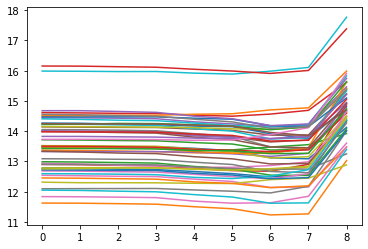

In [4]:
plt.plot(np.array(valid_mses_all).T)
plt.show()

In [5]:
print(np.mean(np.array(best_test_mses)))

13.718963298


In [7]:
np.savetxt('best_test_mses-4d-60.txt', best_test_mses)
np.savetxt('best_train_mses-4d-60.txt', best_train_mses)
np.savetxt('best_lmbdas-4d-60.txt', best_lmbdas)
np.savetxt('valid_all-4d-60.txt', valid_mses_all)
np.savetxt('train_all-4d-60.txt', train_mses_all)

In [ ]:
''' valid 
(2870, 4) (2737,) (133,)
0 14.9376388906 15.1731503814 10.0910603167
(2870, 4) (2737,) (133,)
0.0001 14.920405832 15.1620689693 9.94723284947
(2870, 4) (2737,) (133,)
0.0005 14.8988209519 15.147660956 9.77795560637
(2870, 4) (2737,) (133,)
0.001 14.878752834 15.1297869044 9.71273591076
(2870, 4) (2737,) (133,)
0.005 14.7872877692 15.0374282822 9.63965931733
(2870, 4) (2737,) (133,)
0.01 14.7154935872 14.954560243 9.79575346037
(2870, 4) (2737,) (133,)
0.05 14.5075245911 14.687552447 10.8027408181
(2870, 4) (2737,) (133,)
0.1 14.4784572971 14.5791124305 12.4070806046
'''

In [ ]:
''' test

(2870, 4) (2749,) (122,)
0 15.5656855739 15.5571442124 15.7581462539
(2870, 4) (2749,) (122,)
0.0001 15.562689676 15.5538792725 15.7612126199
(2870, 4) (2749,) (122,)
0.0005 15.5433727933 15.5370509218 15.6858221749
(2870, 4) (2749,) (122,)
0.001 15.5196986896 15.5142377353 15.6427492071
(2870, 4) (2749,) (122,)
0.005 15.3946118151 15.3745978389 15.8455824768
(2870, 4) (2749,) (122,)
0.01 15.2889554896 15.2486543939 16.1970514918
(2870, 4) (2749,) (122,)
0.05 14.8811557373 14.7481397489 17.8783766577
(2870, 4) (2749,) (122,)
0.1 14.6751427666 14.4828863802 19.0072149492
'''

In [32]:
print(valid_mses)

[14.111858369198963, 14.104052629095067, 14.076866404983884, 14.047832679312613, 14.004580717113676, 13.99480858905758, 13.91595634716022, 13.885289393423346, 15.216909046100069]


In [ ]:
''' rand 36
lmbda = 0
test mse 12.8108986929
train mse 2.00672260761e-22

lmbda = 0.0005
test mse 12.7875666563
train mse 0.0113670579467

lmbda = 0.001
test mse 12.7739066581
train mse 0.0226180432005

lmbda = 0.002
test mse 12.7510107579
train mse 0.0432648697909

lmbda = 0.005
test mse 12.6953328728
train mse 0.117089111531

lmbda = 0.01
test mse 12.6381722138
train mse 0.235584867838

lmbda = 0.05
test mse 12.5923957066
train mse 0.972940506562

lmbda = 0.06
test mse 12.6072070239
train mse 1.15752867074
'''

In [ ]:
''' rand= 42
lmbda = 0
test mse 12.6039993663
train mse 2.39847891356e-22

lmbda = 0.0001
test mse 12.5979029216
train mse 0.00179279383533

lmbda = 0.0005
test mse 12.598737754
train mse 0.0164896888952

lmbda = 0.001
test mse 12.598908655
train mse 0.0377804738949

lmbda = 0.5
test mse 14.4296697006
train mse 8.27647092975

lmbda = 1
test mse 16.6157703046
train mse 13.3145125733
'''

In [6]:
from data import Data
import torch
data = Data()
data.train['input'] = torch.from_numpy(X_train_n).float()
data.train['values'] = torch.from_numpy(y_train).float()

data.valid['input'] = torch.from_numpy(X_valid_n).float()
data.valid['values'] = torch.from_numpy(y_valid).float()

data.test['input'] = torch.from_numpy(X_test_n).float()
data.test['values'] = torch.from_numpy(y_test).float()

In [7]:
from NN_trainer import *

nn_trainer = NNTrainer(data, num_epochs=1000, hidden=200, layer=6, batch_size=64, weight_decay = 0, learning_rate=0.001, device='cuda:1')
nn_trainer.train()


==> Preparing data..

Using GPU.
no.  of train samples : 6697

Number of train batches per epoch : 105
no.  of valid samples : 2009

Number of valid batches per epoch : 32
no.  of test samples : 862

Number of test batches per epoch : 14
Number of model parameters is 202201
milestone: [400, 600, 800]

Optimizer :
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)

Scheduler :
cuda:1


Starting training...

Epoch: 0

[  1,    105 /    105] mse: 49057.8210842 | scheduler: epoch - 1; learning rate - [0.001]

Epoch: 1

[  2,    105 /    105] mse: 783.7345295 | scheduler: epoch - 2; learning rate - [0.001]

Epoch: 2

[  3,    105 /    105] mse: 71.3631933 | scheduler: epoch - 3; learning rate - [0.001]

Epoch: 3

[  4,    105 /    105] mse: 39.2253845 | scheduler: epoch - 4; learning rate - [0.001]

Epoch: 4

[  5,    105 /    105] mse: 33.6382854 | scheduler: epoch - 5; learning rate - [0.001]

Epoch

In [ ]:
'''
wd = 0.01

test mse : 14.56269779441247
train mse : 11.290114262564906

wd = 0.001 (run 1)
test mse : 14.560883479668345
train mse : 10.632287500809552

wd = 0.001 (run 2)
test mse : 14.30768097809331
train mse : 10.94075711289028

wd = 0 
test mse : 14.517731436938831
train mse : 10.411961247356862
'''